## Import libraries

In [237]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, r'C:\Users\HP\Desktop\shiftdataportal_data')
from src.sdp_data.utils.translation import CountryTranslatorFrenchToEnglish

## Load Data

In [244]:
# old data (Dataiku)
df_us_eia_oil = pd.read_csv('..//src//sdp_data//data//Fossil_import_export_project//us_eia_oil.csv')
df_us_eia_gas = pd.read_csv('..//src//sdp_data//data//Fossil_import_export_project//us_eia_gas.csv')
df_us_eia_coal = pd.read_csv('..//src//sdp_data//data//Fossil_import_export_project//us_eia_coal.csv')
# new data (using eia api)
eia_api_new = pd.read_csv('..//src//sdp_data//data//_raw//eia//eia_api_intl_1998_2021.csv')
# country data
df_country = pd.read_csv('..//src//sdp_data//data//Country//country_groups_prod.csv')

In [245]:
eia_api_new.head()

,period,productId,productName,activityId,activityName,countryRegionId,countryRegionName,countryRegionTypeId,countryRegionTypeName,dataFlagId,dataFlagDescription,unitName,value,unit
0,1994,26,Dry natural gas,1,Production,BTN,Bhutan,c,Country,NaN,NaN,million metric tons of oil equivalent,0,MTOE
1,1982,26,Dry natural gas,1,Production,ISR,Israel,c,Country,NaN,NaN,terajoules,3288.60909261654,TJ
2,1982,26,Dry natural gas,1,Production,ISR,Israel,c,Country,5.0,"A value exists, but rounds to zero; non-rounde...",million metric tons of oil equivalent,.0785470787037,MTOE
3,1993,79,Biofuels,1,Production,NRU,Nauru,c,Country,NaN,NaN,thousand barrels per day,0,TBPD
4,2019,79,Biofuels,1,Production,EGY,Egypt,c,Country,NaN,NaN,million metric tons of oil equivalent,0,MTOE


In [246]:
eia_api_new.unit.unique()

array(['MTOE', 'TJ', 'TBPD', 'QBTU', 'BCF', 'MT', 'TST', 'BCM', 'BKWH',
       'MBBL', 'TCF', 'BB', 'MST', 'MK', 'MMTCD', 'MBTUPP', 'THP',
       'TBTUUSDPP', 'BDOLPPP'], dtype=object)

## Traduction Dataiku => python (avec données ancien)

In [161]:
class FossilProvenReservesProdGeneratorOLD:
    
    def __init__(self):
        # Initialize any necessary variables or state here
        pass
        
    def process(self, df):
        df["year"] = df["year"].astype(int)
        df["energy"] = df["energy"].str.replace(" ", "").replace("-", "")
        df['energy'] = pd.to_numeric(df['energy'], errors='coerce')
        return df


        return row
    def run(self, df_us_eia_oil, df_us_eia_gas, df_us_eia_coal, df_country):
        df_us_eia_oil = pd.melt(df_us_eia_oil, id_vars=["country", "energy_unit", "energy_source", "type", "subtype", "subsubtype", "subsubsubtype"], var_name='year', value_name='energy')
        df_us_eia_gas = pd.melt(df_us_eia_gas, id_vars=["country", "energy_unit", "energy_source", "type", "subtype", "subsubtype"], var_name='year', value_name='energy')
        df_us_eia_coal = pd.melt(df_us_eia_coal, id_vars=["country", "energy_unit", "energy_source", "type", "subtype"], var_name='year', value_name='energy')

        df_us_eia_gas = df_us_eia_gas[df_us_eia_gas.subtype=='Gross natural gas'].reset_index(drop=True)
        df_us_eia_coal = df_us_eia_coal[df_us_eia_coal.subtype=='Total primary coal'].reset_index(drop=True)
        
        df_us_eia_oil.drop(columns=["subtype", "subsubtype", "subsubsubtype"], axis=1, inplace=True)
        df_us_eia_gas.drop(columns=["subtype", "subsubtype"], axis=1, inplace=True)
        df_us_eia_coal.drop(columns=["subtype"], axis=1, inplace=True)

        df_us_eia_oil['energy_source'] = 'Oil'
        df_us_eia_gas['energy_source'] = 'Gas'
        df_us_eia_coal['energy_source'] = 'Coal'
        
        df_grouped = pd.concat([df_us_eia_oil, df_us_eia_gas, df_us_eia_coal]).reset_index(drop=True)

        df_grouped["energy_unit"].replace("MMTOE", "Mtoe", inplace=True)
        df_grouped["source"] = "US EIA"
        df_grouped = df_grouped[df_grouped.type.isin(['Imports','Exports', 'Imports Net'])].reset_index(drop=True)
        df_grouped = self.process(df_grouped)
        df_grouped.dropna(subset='energy', inplace=True)
        df_grouped["country"] = CountryTranslatorFrenchToEnglish().run(df_grouped["country"], raise_errors=False)
        df_grouped = df_grouped[df_grouped["country"] != "Delete"] 
        df_grouped.rename(columns={'country': 'group_name'}, inplace=True)
        df_grouped= df_grouped.reset_index(drop=True)
        df_grouped.drop_duplicates(subset=['year', 'energy_source', 'type', 'group_name'], inplace=True)

        df_net_imports = df_grouped.copy()
        df_net_imports['energy'] = df_net_imports.apply(lambda x: x['energy'] if x['type']=='Imports' else -x['energy'], axis=1)
        df_net_imports = df_net_imports[df_net_imports['type'].notnull()]
        df_net_imports = df_net_imports.groupby(['group_name', 'energy_unit', 'energy_source', 'year', 'source'])['energy'].sum().reset_index()
        df_net_imports['type'] = 'Net Imports'
        df_grouped = df_grouped[df_grouped['type'].notnull()]
        df_final = pd.concat([df_net_imports, df_grouped]).reset_index(drop=True)                               

        return df_grouped
       

In [162]:
res_old = FossilProvenReservesProdGeneratorOLD().run(df_us_eia_oil, df_us_eia_gas, df_us_eia_coal, df_country)
res_old

,group_name,energy_unit,energy_source,type,year,energy,source
0,Afghanistan,Mb/d,Oil,Imports,1980,0.000000,US EIA
1,Albania,Mb/d,Oil,Imports,1980,0.000000,US EIA
2,Algeria,Mb/d,Oil,Imports,1980,3.232000,US EIA
3,American Samoa,Mb/d,Oil,Imports,1980,0.000000,US EIA
4,Angola,Mb/d,Oil,Imports,1980,0.000000,US EIA
...,...,...,...,...,...,...,...
42462,Wake Island,Mtoe,Coal,Exports,2016,0.000000,US EIA
42463,Western Sahara,Mtoe,Coal,Exports,2016,0.000000,US EIA
42464,Yemen,Mtoe,Coal,Exports,2016,0.000000,US EIA
42465,Zambia,Mtoe,Coal,Exports,2016,0.000965,US EIA


## Traduction Dataiku => python + adaptation du code au nouveau format des données récentes + amélioration du code

In [163]:
def common_indices(df_0, df_1):
    return list(set(df_0.index) & set(df_1.index))
    
def function_coef_unit_stats(df, energy_source, unit_ref, unit):
    # Filtering
    df_unit_ref = df[(df.energy_source==energy_source)&(df.energy_unit==unit_ref)].set_index(['year', 'group_name', 'type'])
    df_unit = df[(df.energy_source==energy_source)&(df.energy_unit==unit)].set_index(['year', 'group_name', 'type'])
    
    # Finding common indices
    indices = common_indices(df_unit_ref, df_unit)

    # Locating common indices
    df_unit_common = df_unit.loc[indices]
    df_unit_ref_common = df_unit_ref.loc[indices]

    ratio = df_unit_ref_common.energy/df_unit_common.energy
    ratio = ratio[(ratio>0.000001)&(ratio<10000)]
    
    # Returning statistics including Coefficient of Variation (CV)    
    return ratio.min(), ratio.max(), ratio.median(), ratio.mean(), ratio.std()/ratio.mean() #Coefficient of Variation (CV)

#for key in cl.dict_unit['Coal'].keys():
#    min_, max_, median_, mean_, cv_ = function_coef_unit_stats(res, 'Coal', 'MTOE', key)
#    print(key, cv_, mean_, median_)

In [164]:
class FossilProvenReservesProdGeneratorNEW:
    
    def __init__(self):
        # Initialize any necessary variables or state here
        # pour coal: le coeff de conversion est constante de MTOE à TJ, QBTU .. 
        # donc au cas où il manque une donnée exprimé MTOE, je regarde les autres donées avec unités TJ, QBTU
        # Cela permet de minimiser le nbre de valeurs manquantes.
        # pour gas: le coeff de conversion est constante de BCF à BCM
        # pour pétrole : données récentes sont exprimées par TBPD
        self.dict_units_coef = {'Oil':{'TBPD':1}, 'Coal':{'MTOE':1, 'TJ':2.38*10**(-5), 'QBTU': 25.199},
                          'Gas':{'BCF':1, 'BCM': 35.3147}}      
        self.default_unit = {'Oil': 'TBPD', 'Coal': 'MTOE', 'Gas': 'BCF'}
        
    def process(self, df):
        df = df.dropna(subset=['value'])
        df = df.reset_index(drop=True)
        df = df[['period', 'productName', 'activityName', 'countryRegionName', 'unit', 'value']]
        column_renames = {
            'period': 'year', 
            'productName': 'energy_source', 
            'activityName': 'type', 
            'countryRegionName': 'group_name', 
            'unit': 'energy_unit', 
            'value': 'energy'
        }
        df.rename(columns=column_renames, inplace=True)
        df["year"] = df["year"].astype(int)
        df["energy"] = df["energy"].str.replace(" ", "").replace("-", "")
        df['energy'] = pd.to_numeric(df['energy'], errors='coerce')
        
        return df
        
    def convert_units(self, row):
        # Conversion des unités d'énergie
        return self.dict_unit[row['energy_source']][row['energy_unit']] * row['energy']

    def exports_imports_data(self, eia_api, df_country):

        eia_api = self.process(eia_api)
        eia_api = eia_api[eia_api.type.isin(['Imports','Exports'])].reset_index(drop=True)
        eia_api = eia_api[eia_api.energy_source.isin(['Crude oil including lease condensate', 'Dry natural gas', 'Coal'])].reset_index(drop=True)
        eia_api.energy_source.replace({'Crude oil including lease condensate': 'Oil', 'Dry natural gas': 'Gas'}, inplace=True)
        eia_api = eia_api[(eia_api.energy_source=='Oil')&(eia_api.energy_unit=='TBPD')|(eia_api.energy_source=='Gas')&(eia_api.energy_unit.isin(['BCF','BCM']))|(eia_api.energy_source=='Coal')&(eia_api.energy_unit.isin(['MTOE','TJ', 'QBTU']))]
        eia_api['energy'] =  eia_api.apply(lambda x: self.dict_units_coef[x['energy_source']][x['energy_unit']]*x['energy'], axis=1)
        eia_api['energy_unit'] = eia_api['energy_source'].map(self.default_unit)
        #eia_api.drop_duplicates(subset=['year', 'energy_source', 'type', 'group_name'], inplace=True)
        eia_api["source"] = "US EIA"
        eia_api.dropna(subset='energy', inplace=True)
        eia_api.drop_duplicates(inplace=True)
        eia_api= eia_api.reset_index(drop=True)
        eia_api['group_name'] = CountryTranslatorFrenchToEnglish().run(eia_api['group_name'], raise_errors=False)
        eia_api = eia_api[eia_api['type'].notnull()]
        eia_api.drop_duplicates(subset=['year', 'energy_source', 'type', 'group_name'], inplace=True)

        return eia_api
        
    def net_imports_data(self, df):
        
        df_net_imports = df.copy()
        df_net_imports['energy'] = df.apply(lambda x: x['energy'] if x['type']=='Imports' else -x['energy'], axis=1)
        df_net_imports = df_net_imports[df_net_imports['type'].notnull()]
        df_net_imports = df_net_imports.groupby(['group_name', 'energy_unit', 'energy_source', 'year', 'source'])['energy'].sum().reset_index()
        df_net_imports['type'] = 'Net Imports'
        
        return df_net_imports

    def run(self, eia_api, df_country):
        eia_api_ = self.exports_imports_data(eia_api, df_country)
        df_net_imports_ = self.net_imports_data(eia_api_)
        df_final = pd.concat([df_net_imports_, eia_api_]).reset_index(drop=True)                               

        return df_final
       

In [196]:
cl = FossilProvenReservesProdGeneratorNEW()
res_new = cl.run(eia_api_new.copy(), df_country)

Please, check the following list :
['GM offshore used for load only', 'NL offshore used for load only', 'Timor-Leste ', 'UK offshore used for load only']


In [197]:
res_new.head()

,group_name,energy_unit,energy_source,year,source,energy,type
0,Afghanistan,BCF,Gas,1990,US EIA,-36.209295,Net Imports
1,Afghanistan,BCF,Gas,1991,US EIA,0.000000,Net Imports
2,Afghanistan,BCF,Gas,1992,US EIA,0.000000,Net Imports
3,Afghanistan,BCF,Gas,1993,US EIA,0.000000,Net Imports
4,Afghanistan,BCF,Gas,1994,US EIA,0.000000,Net Imports


### Check values difference between old data and new data

In [241]:
res_old_oil = res_old[res_old.energy_source=='Oil']
res_new_oil = res_new[res_new.energy_source=='Oil']

In [242]:
res_old_ = res_old_oil.set_index(['year', 'group_name', 'type', 'energy_source'])
res_new_ = res_new_oil.set_index(['year', 'group_name', 'type', 'energy_source'])
# Finding common indices
indices = common_indices(res_old_, res_new_)
res_old_common_indices = res_old_.loc[indices]
res_new_common_indices = res_new_.loc[indices]

### Evaluation statistique des différences entre les anciennes et les nouvelles données (intersection)
####  interprétations : 
La plupart des points se trouvent sur ou très proche de la ligne qui indiquerait où les valeurs anciennes et nouvelles sont égales. Cela suggère que, pour la majorité des données, la mise à jour n'a pas entraîné de changements significatifs.

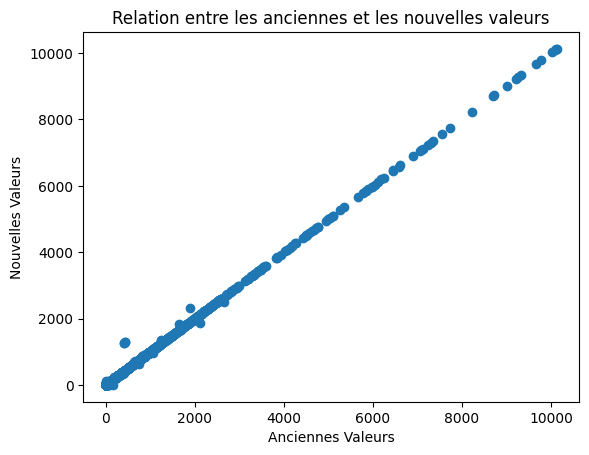

In [243]:
plt.scatter(res_old_common_indices['energy'], res_new_common_indices['energy'])
plt.title('Relation entre les anciennes et les nouvelles valeurs')
plt.xlabel('Anciennes Valeurs')
plt.ylabel('Nouvelles Valeurs')
plt.show()